```
This software is part of GPU Ocean. 

Copyright (C) 2018, 2019 SINTEF Digital

This notebook reads the result from benchmarking perforance
across optimization stages of shallow water simulation code.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
%matplotlib inline

import time
import json
import socket

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rc

In [2]:
font = {'family' : 'serif',
        'size'   : '22',
       }

rc('font', **font) 
rc('text', usetex=True)
rc('axes', axisbelow=True)

savefigs = False

## Load data into a Pandas dataframe

In [3]:
cdklm_cuda = (
    ("scripts/laptop/cdklm_cuda_git_versions_laptop_2018_10_11-17_57_28.npz", "840M"),
    ("scripts/met/cdklm_cuda_git_versions_met_2018_10_12-16_18_55.npz", "M2090"),
    ("scripts/abel/cdklm_cuda_git_versions_abel_2018_10_12-18_22_22.npz", "K20"),
    ("scripts/desktop/cdklm_cuda_git_versions_desktop_2018_10_11-16_39_52.npz", "GTX780"),
    ("scripts/amazon_k80/cdklm_cuda_git_versions_amazon_k80_2018_10_12-13_01_04.npz", "K80"),
    ("scripts/amazon_v100/cdklm_cuda_git_versions_amazon_v100_2018_10_12-21_15_12.npz", "V100"),
    #("supercomputer_fermi_cdklm_profiling.npz", "V100")
)

cdklm_opencl = (
    ("scripts/laptop/cdklm_opencl_git_versions_laptop_2018_10_12-15_04_36.npz", "840M"),
    ("scripts/met/cdklm_opencl_git_versions_met_2018_10_12-16_20_14.npz", "M2090"),
    ("scripts/abel/cdklm_opencl_git_versions_abel_2018_10_12-18_23_21.npz", "K20"),
    ("scripts/desktop/cdklm_opencl_git_versions_desktop_2018_10_12-14_58_02.npz", "GTX780"),
    ("scripts/amazon_k80/cdklm_opencl_git_versions_amazon_k80_2018_10_12-13_01_20.npz", "K80"),
    ("scripts/amazon_v100/cdklm_opencl_git_versions_amazon_v100_2018_10_12-21_15_19.npz", "V100"),
)

ctcs_cuda =  (
    ("scripts/laptop/ctcs_cuda_git_versions_laptop_2018_10_11-18_26_56.npz", "840M"),
    ("scripts/met/ctcs_cuda_git_versions_met_2018_10_12-16_22_59.npz", "M2090"),
    ("scripts/abel/ctcs_cuda_git_versions_abel_2018_10_12-18_25_57.npz", "K20"),
    ("scripts/desktop/ctcs_cuda_git_versions_desktop_2018_10_11-17_12_47.npz", "GTX780"),
    ("scripts/amazon_k80/ctcs_cuda_git_versions_amazon_k80_2018_10_12-13_02_19.npz", "K80"),
    ("scripts/amazon_v100/ctcs_cuda_git_versions_amazon_v100_2018_10_12-21_15_50.npz", "V100"),
)
ctcs_opencl =  (
    ("scripts/laptop/ctcs_opencl_git_versions_laptop_2018_10_12-15_03_29.npz", "840M"),
    ("scripts/met/ctcs_opencl_git_versions_met_2018_10_12-16_23_30.npz", "M2090"),
    ("scripts/abel/ctcs_opencl_git_versions_abel_2018_10_12-18_27_02.npz", "K20"),
    ("scripts/desktop/ctcs_opencl_git_versions_desktop_2018_10_12-09_44_56.npz", "GTX780"),
    ("scripts/amazon_k80/ctcs_opencl_git_versions_amazon_k80_2018_10_12-13_02_31.npz", "K80"),
    ("scripts/amazon_v100/ctcs_opencl_git_versions_amazon_v100_2018_10_12-21_15_58.npz", "V100"),
)

fbl_cuda = (
    ("scripts/laptop/fbl_cuda_git_versions_laptop_2018_10_11-18_43_38.npz", "840M"),
    ("scripts/met/fbl_cuda_git_versions_met_2018_10_12-16_25_14.npz", "M2090"),
    ("scripts/abel/fbl_cuda_git_versions_abel_2018_10_12-18_28_39.npz", "K20"),
    ("scripts/desktop/fbl_cuda_git_versions_desktop_2018_10_11-17_13_43.npz", "GTX780"),
    ("scripts/amazon_k80/fbl_cuda_git_versions_amazon_k80_2018_10_12-13_02_55.npz", "K80"),
    ("scripts/amazon_v100/fbl_cuda_git_versions_amazon_v100_2018_10_12-21_16_13.npz", "V100"),
)

fbl_opencl = (
    ("scripts/laptop/fbl_opencl_git_versions_laptop_2018_10_12-15_02_36.npz", "840M"),
    ("scripts/met/fbl_opencl_git_versions_met_2018_10_12-16_25_46.npz", "M2090"),
    ("scripts/abel/fbl_opencl_git_versions_abel_2018_10_12-18_29_51.npz", "K20"),
    ("scripts/desktop/fbl_opencl_git_versions_desktop_2018_10_12-14_56_57.npz", "GTX780"),
    ("scripts/amazon_k80/fbl_opencl_git_versions_amazon_k80_2018_10_12-13_03_06.npz", "K80"),
    ("scripts/amazon_v100/fbl_opencl_git_versions_amazon_v100_2018_10_12-21_16_20.npz", "V100"),
)

gigaflops = np.array([790, 1331, 3524, 3977, 8736/2, 14899])
bandwidth = np.array([16, 178, 208, 288, 240, 900])

In [4]:
def make_df(files):
    #Create column names
    columns = ["labels"]
    for _, label in files:
        columns = columns + ["megacells " + label]

    #Create index names:
    with np.load(files[0][0], allow_pickle=True) as data:
        index = data['versions']
        labels = data['labels']

    df = pd.DataFrame(columns=columns, index=index)
    df['labels'] = labels

    for filename, label in files:
        with np.load(filename, allow_pickle=True) as data:
            versions = data['versions']
            assert np.all(versions == df.index)
            df["megacells " + label] = data['megacells']

    return df, versions 

840M [1.0, 0.5938483433708361, 1.7852009772813808, 2.0660288077207585]
M2090 [1.0, 0.5013234312649769, 1.6934830489181387, 1.6538692210788608]
K20 [1.0, 0.5434037616419571, 3.0493014522458206, 2.9738479569928926]
GTX780 [1.0, 0.5482531111579836, 3.0889169346462553, 3.0298736420012125]
K80 [1.0, 0.5582467473339561, 1.6060992248428476, 1.3492513422667014]
V100 [1.0, 0.6155619974288523, 1.4958664523527163, 1.5037661953790826]
840M [1.0, 0.5938483433708361, 1.7852009772813808, 2.0660288077207585]
M2090 [1.0, 0.5013234312649769, 1.6934830489181387, 1.6538692210788608]
K20 [1.0, 0.5434037616419571, 3.0493014522458206, 2.9738479569928926]
GTX780 [1.0, 0.5482531111579836, 3.0889169346462553, 3.0298736420012125]
K80 [1.0, 0.5582467473339561, 1.6060992248428476, 1.3492513422667014]
V100 [1.0, 0.6155619974288523, 1.4958664523527163, 1.5037661953790826]


/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/ipykernel_launcher.py:100: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/ipykernel_launcher.py:100: UserWarning: Unknown infodict keyword: original_files
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/ipykernel_launcher.py:100: UserWarning: Unknown infodict keyword: original_data
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/ipykernel_launcher.py:100: UserWarning: Unknown infodict keyword: created
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/ipykernel_launcher.py:100: UserWarning: Unknown infodict keyword: hostname


840M [1.0, 0.5938483433708361, 1.7852009772813808, 2.0660288077207585]
GTX780 [1.0, 0.5482531111579836, 3.0889169346462553, 3.0298736420012125]
V100 [1.0, 0.6155619974288523, 1.4958664523527163, 1.5037661953790826]


/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<Figure size 432x288 with 0 Axes>

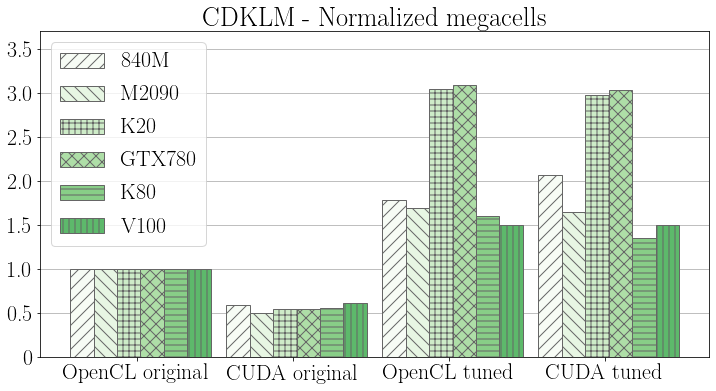

<Figure size 432x288 with 0 Axes>

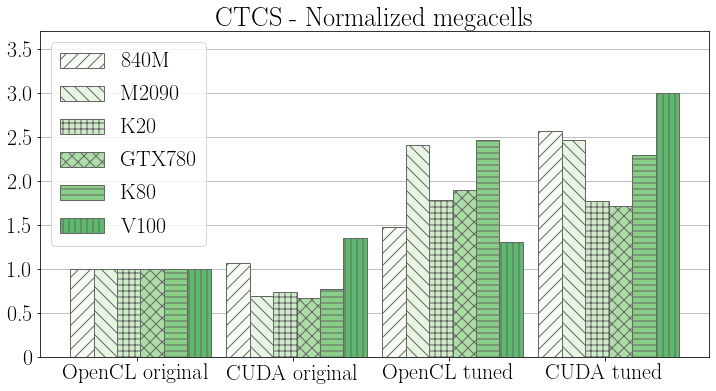

<Figure size 432x288 with 0 Axes>

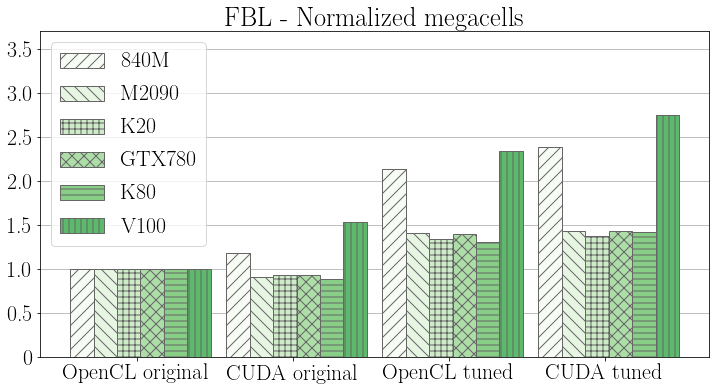

<Figure size 432x288 with 0 Axes>

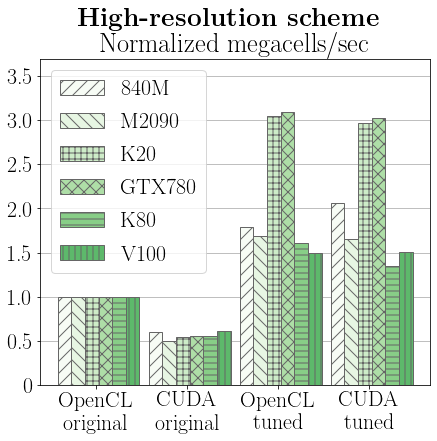

<Figure size 432x288 with 0 Axes>

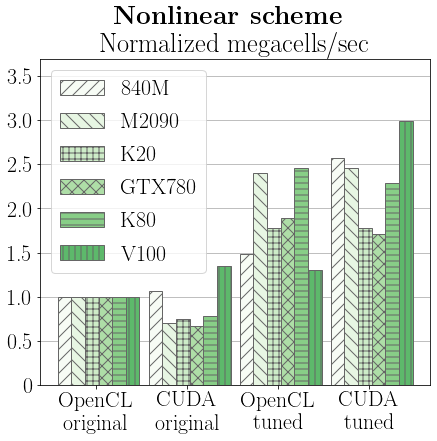

<Figure size 432x288 with 0 Axes>

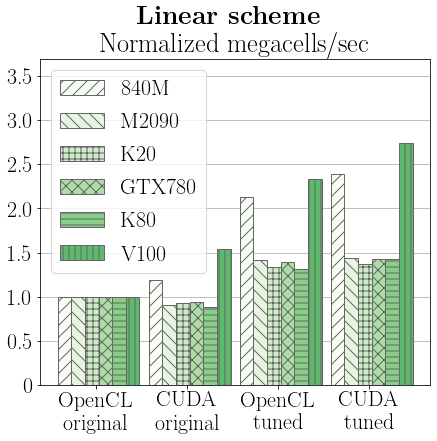

<Figure size 432x288 with 0 Axes>

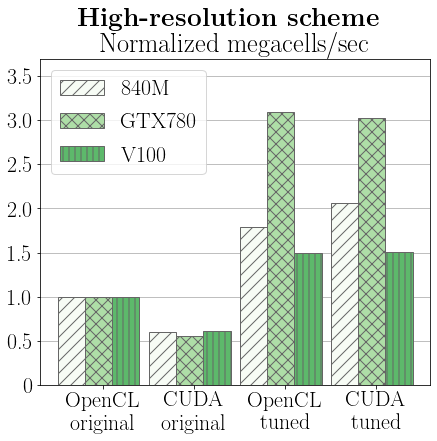

<Figure size 432x288 with 0 Axes>

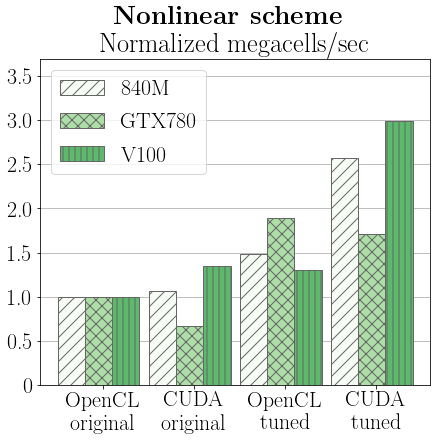

<Figure size 432x288 with 0 Axes>

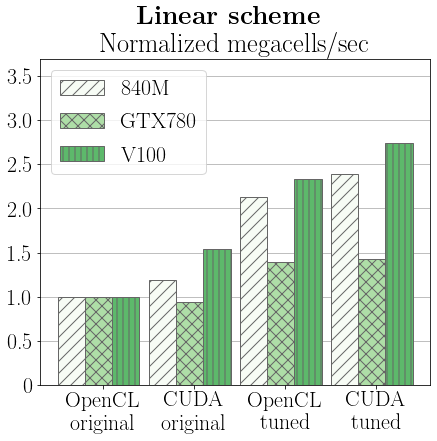

<Figure size 432x288 with 0 Axes>

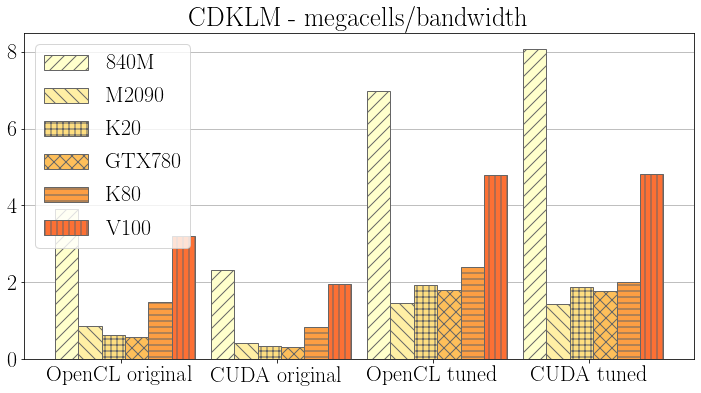

<Figure size 432x288 with 0 Axes>

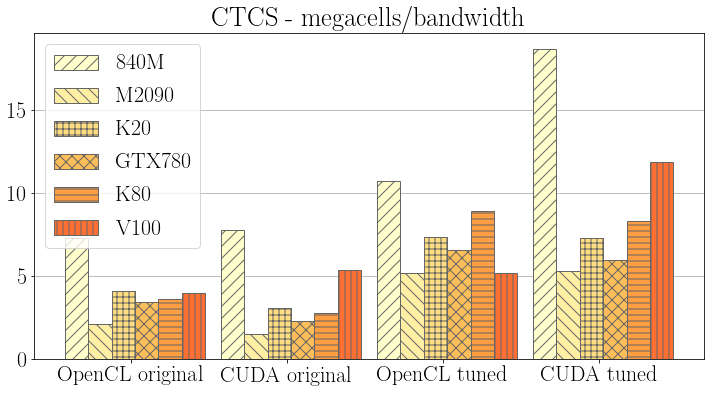

<Figure size 432x288 with 0 Axes>

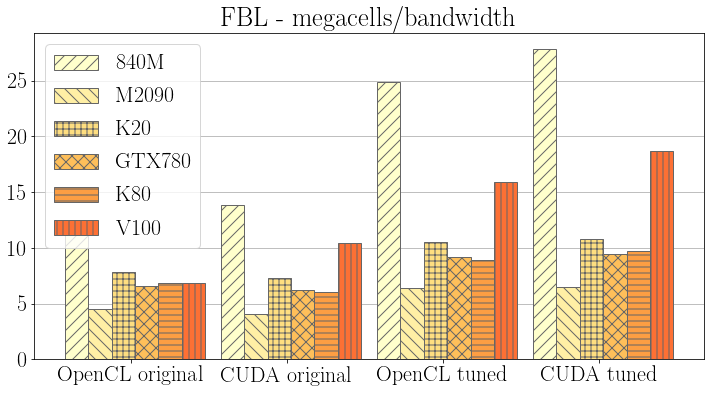

In [46]:
def plot_cuda_vs_opencl_results(opencl_files, cuda_files, title, filename=None, normalization=None, 
                                print_values=False, save_this=False, largefont=False,
                                suptitle=None, subset=None):
    assert len(opencl_files) == len(cuda_files)
    
    opencl_df, _ = make_df(opencl_files)
    cuda_df, _ = make_df(cuda_files)
    
    fig = plt.figure()
    
    if largefont:
        fig, ax = plt.subplots(figsize=(7,6))
    else:
        fig, ax = plt.subplots(figsize=(12,6))

    num_bars = len(opencl_files)
    if subset is not None:
        num_bars = len(subset)
    bar_width = 0.9 / num_bars
    bar_offset = 0.05

    x = np.arange(4)
    architectures = list(zip(*opencl_files))[1]
    if subset is not None:
        architectures = [architectures[i] for i in subset]
        
        
    num_architectures = len(architectures)
    
    #print(opencl_df)
    #print(cuda_df)
    
    hatches = ['//', '\\\\', '++', 'xx', '--', '||', '..', '**']
    if (normalization is None):
        cmap = plt.get_cmap("Greens")
    elif (normalization is False):
        cmap = plt.get_cmap("Reds")
    else:
        cmap = plt.get_cmap("YlOrRd")
    colors = cmap(np.arange(6)/9)
    

    for i, label in enumerate(architectures):
        ocl_values = opencl_df['megacells ' + label]
        cuda_values = cuda_df['megacells ' + label]
        
        if (normalization is None):
            n = 1 / ocl_values[0]
        elif (normalization is False):
            n = 1.0
        else:
            n = 1.0/normalization[i]
        
        ocl_values = ocl_values*n
        cuda_values = cuda_values*n
        
        values = [ocl_values[0], cuda_values[0], ocl_values[-1], cuda_values[-1]]
        if print_values:
            print(label, values)
            
        if subset is None:
            ax.bar(x+2*bar_offset + (i - num_architectures/2)*bar_width, values, bar_width, 
                   label=label, hatch=hatches[i], color=colors[i], linewidth=1, edgecolor='0.4')
        else:
            ax.bar(x+2*bar_offset + (i - num_architectures/2)*bar_width, values, bar_width, 
               label=label, hatch=hatches[subset[i]], color=colors[subset[i]], linewidth=1, edgecolor='0.4')

    labels = ["OpenCL original", "CUDA original", "OpenCL tuned", "CUDA tuned"]
    if largefont:
        labels = ["OpenCL \n original", "CUDA \n original", "OpenCL \n tuned", "CUDA \n tuned"]
    
    plt.xticks(x, labels)#, rotation='vertical')
    plt.grid(axis='y')
    
    if (normalization is None):
        #plt.ylim([0, 3.5])
        #plt.yticks([0, 1, 2, 3], [0, 1, 2, 3])
        plt.ylim([0, 3.7])
        plt.yticks([0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5], [0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5])

        
        
    plt.legend(loc='upper left')
    
    plt.title(title)
    
    if suptitle is not None:
        plt.suptitle(suptitle, y=1.0)
        
    if(filename):
        metadata = {
                    'original_files': json.dumps({"OpenCL": opencl_files, "CUDA": cuda_files}), 
                    'original_data': json.dumps({"OpenCL":opencl_df.to_csv(), "CUDA": cuda_df.to_csv()}), 
                    'created': time.strftime("%Y_%m_%d-%H_%M_%S"),
                    'hostname': socket.gethostname()
                    }
        if savefigs or save_this:
            plt.savefig(filename, dpi=300,format='pdf',
                    transparent=True, pad_inches=0.0, frameon=None, 
                    metadata=metadata)
    
    
plot_cuda_vs_opencl_results(cdklm_opencl, cdklm_cuda, "CDKLM - Normalized megacells", "tuning_cdklm.pdf", print_values=True)
plot_cuda_vs_opencl_results(ctcs_opencl, ctcs_cuda, "CTCS - Normalized megacells", "tuning_ctcs.pdf")
plot_cuda_vs_opencl_results(fbl_opencl, fbl_cuda, "FBL - Normalized megacells", "tuning_fbl.pdf")

plot_cuda_vs_opencl_results(cdklm_opencl, cdklm_cuda, 'Normalized megacells/sec', "tuning_cdklm_high_res.pdf",
                            suptitle=r'\textbf{High-resolution scheme}', print_values=True, largefont=True, 
                            save_this=True,)
plot_cuda_vs_opencl_results(ctcs_opencl, ctcs_cuda, 'Normalized megacells/sec', "tuning_ctcs_nonlin.pdf", 
                            suptitle=r'\textbf{Nonlinear scheme}', largefont=True, 
                            save_this=True)
plot_cuda_vs_opencl_results(fbl_opencl, fbl_cuda, 'Normalized megacells/sec', "tuning_fbl_lin.pdf", 
                            suptitle=r'\textbf{Linear scheme}', largefont=True, 
                            save_this=True)

plot_cuda_vs_opencl_results(cdklm_opencl, cdklm_cuda, 'Normalized megacells/sec', "tuning_cdklm_high_res_subset.pdf",
                            suptitle=r'\textbf{High-resolution scheme}', print_values=True, largefont=True, 
                            save_this=True, subset=[0, 3, 5])
plot_cuda_vs_opencl_results(ctcs_opencl, ctcs_cuda, 'Normalized megacells/sec', "tuning_ctcs_nonlin_subset.pdf", 
                            suptitle=r'\textbf{Nonlinear scheme}', largefont=True, 
                            save_this=True, subset=[0, 3, 5])
plot_cuda_vs_opencl_results(fbl_opencl, fbl_cuda, 'Normalized megacells/sec', "tuning_fbl_lin_subset.pdf", 
                            suptitle=r'\textbf{Linear scheme}', largefont=True, 
                            save_this=True, subset=[0, 3, 5])


plot_cuda_vs_opencl_results(cdklm_opencl, cdklm_cuda, "CDKLM - megacells/bandwidth", "tuning_gflops_cdklm.pdf", normalization=bandwidth)
plot_cuda_vs_opencl_results(ctcs_opencl, ctcs_cuda, "CTCS - megacells/bandwidth", "tuning_gflops_ctcs.pdf", normalization=bandwidth)
plot_cuda_vs_opencl_results(fbl_opencl, fbl_cuda, "FBL - megacells/bandwidth", "tuning_gflops_fbl.pdf", normalization=bandwidth)

## Plot results

In [6]:
def plot_results(files, title, columns=None, labels=None, filename=None):
    df, versions = make_df(files)

    num_bars = len(files)
    bar_width = 0.9 / num_bars
    bar_offset = 0.05
    
    if (columns == None):
        columns = np.arange(len(versions))
        
    if (labels == None):
        labels = df['labels'][columns]
    
    assert (len(labels)== len(columns))
        
        
    label_rotation = 0
    fig_width = 12
    alignment = 'center'
    if len(labels) > 4:
        #label_rotation = 15
        #alignment = 'right'
        fig_width = fig_width*len(labels)/4.0
        
    fig = plt.figure()
    fig, ax = plt.subplots(figsize=(fig_width,6))

        
    x = np.arange(len(columns))
    architectures = list(zip(*files))[1]
    num_architectures = len(architectures)
        
    hatches = ['//', '\\\\', '++', 'xx', '--', '||', '..', '**']
    cmap = plt.get_cmap("Greens")
    colors = cmap(np.arange(len(architectures))/9)

    for i, label in enumerate(architectures):
        values = df['megacells ' + label]
        values = values / values[0] #Normalize
        values = values[columns]
        ax.bar(x+2*bar_offset + (i - num_architectures/2)*bar_width, values, bar_width,
               label=label, hatch=hatches[i], color=colors[i], linewidth=1, edgecolor='0.4')

    plt.xticks(x, labels, rotation=label_rotation, horizontalalignment=alignment) #rotation='vertical')
    #for label in axs[0].get_xmajorticklabels() + axs[1].get_xmajorticklabels():
    #    label.set_rotation(30)
    #    label.set_horizontalalignment("right")
    
    plt.grid(axis='y')
    plt.legend(loc='upper left')
    plt.ylim([0, 6])
    plt.yticks([0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5])
    
    plt.title(title)
    if(filename):
        metadata = {
                    'original_files': json.dumps(files), 
                    'original_data': json.dumps(df.to_csv()), 
                    'created': time.strftime("%Y_%m_%d-%H_%M_%S"),
                    'hostname': socket.gethostname()
                    }
        if savefigs:
            plt.savefig(filename, dpi=300,format='pdf',
                    transparent=True, pad_inches=0.0, frameon=None, 
                    metadata=metadata)


<Figure size 432x288 with 0 Axes>

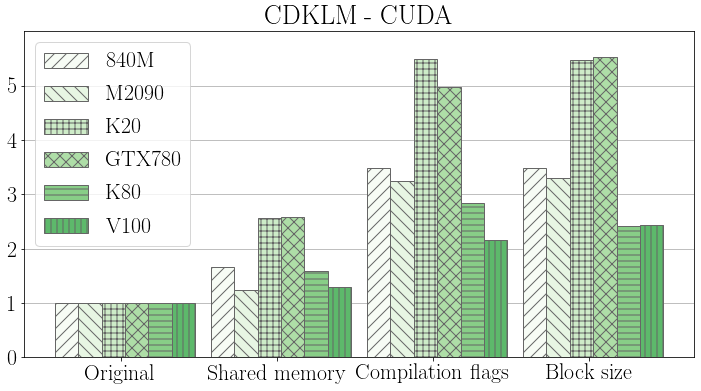

<Figure size 432x288 with 0 Axes>

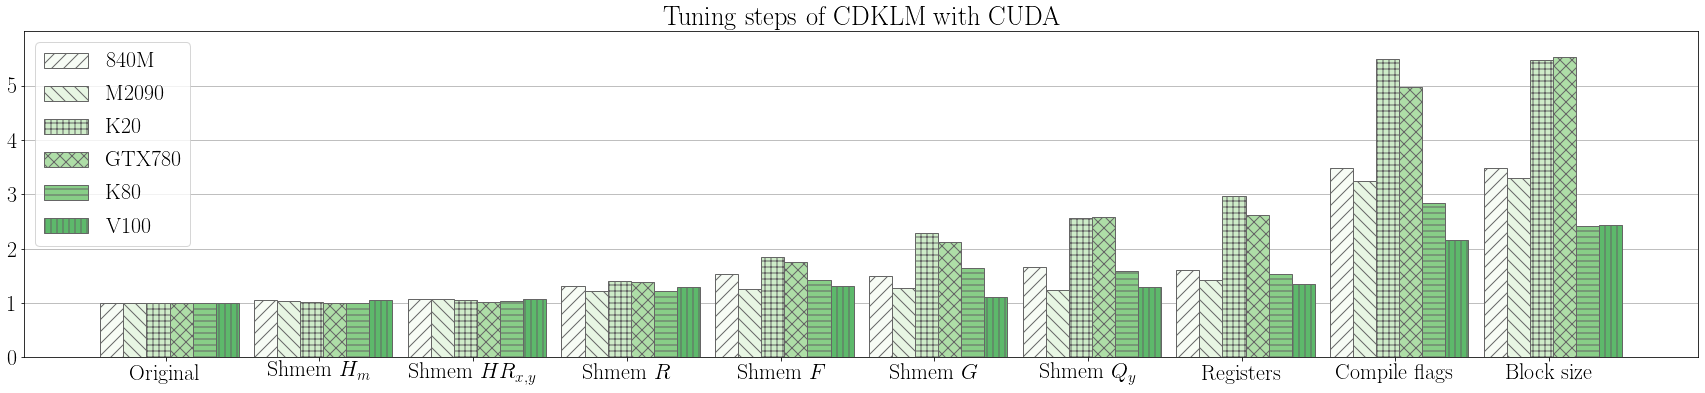

<Figure size 432x288 with 0 Axes>

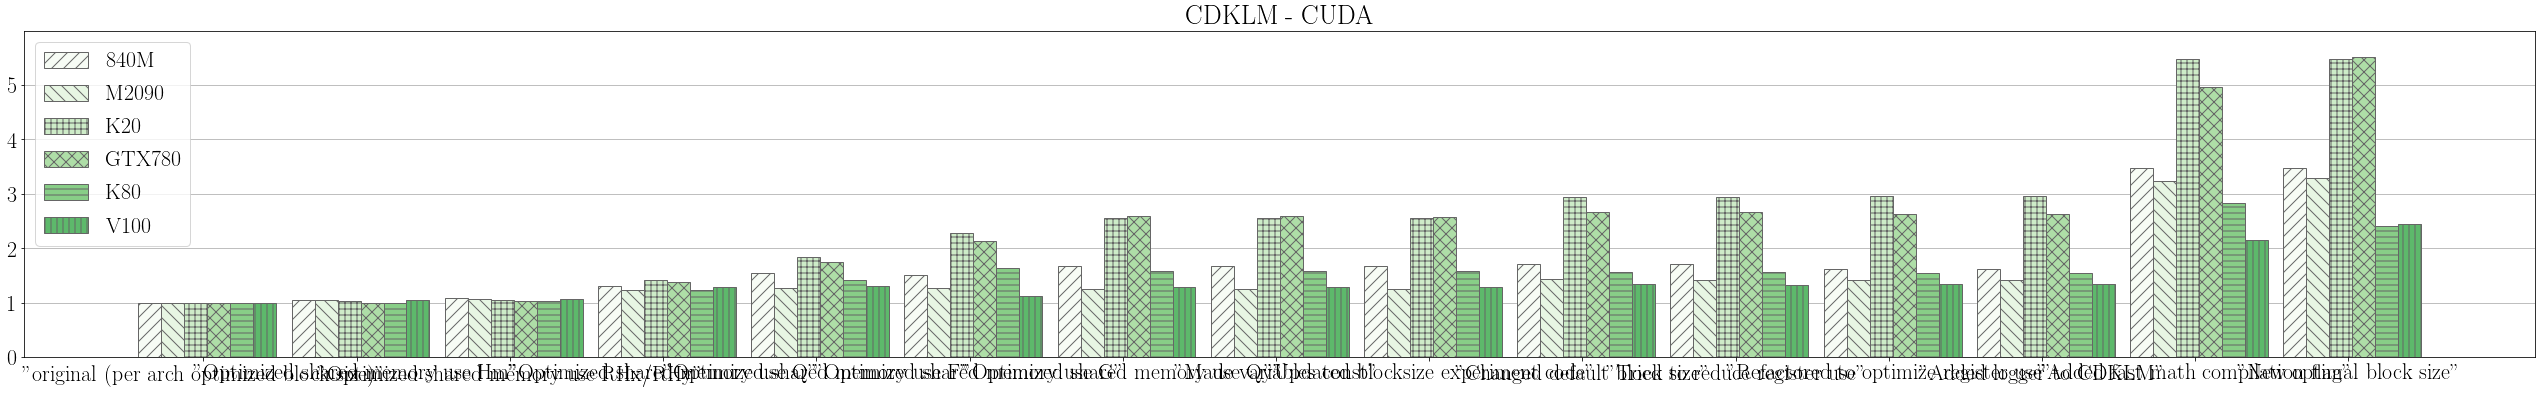

<Figure size 432x288 with 0 Axes>

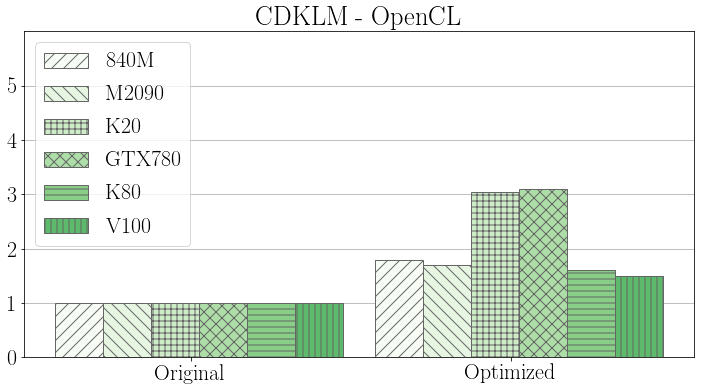

In [7]:
plot_results(cdklm_cuda, "CDKLM - CUDA", columns=[0, 6, 13, 14], labels=["Original", "Shared memory", "Compilation flags", "Block size"], filename="cuda_cdklm.pdf")
shmem = "Shmem "
plot_results(cdklm_cuda, "Tuning steps of CDKLM with CUDA", 
             columns=[0,1,2,3,4,5,6, 12, 13, 14],
             labels=["Original", 
                     shmem + "$H_m$",
                     shmem + "$HR_{x,y}$",
                     shmem + "$R$",
                     shmem + "$F$",
                     shmem + "$G$",
                     shmem + "$Q_y$",
                     "Registers",
                     "Compile flags", 
                     "Block size"], 
             filename="cuda_cdklm_tuning.pdf")
plot_results(cdklm_cuda, "CDKLM - CUDA", 
             columns=None, labels=None, 
             filename="cuda_cdklm_all.pdf")
plot_results(cdklm_opencl, "CDKLM - OpenCL", labels=["Original", "Optimized"], filename="opencl_cdklm.pdf")

<Figure size 432x288 with 0 Axes>

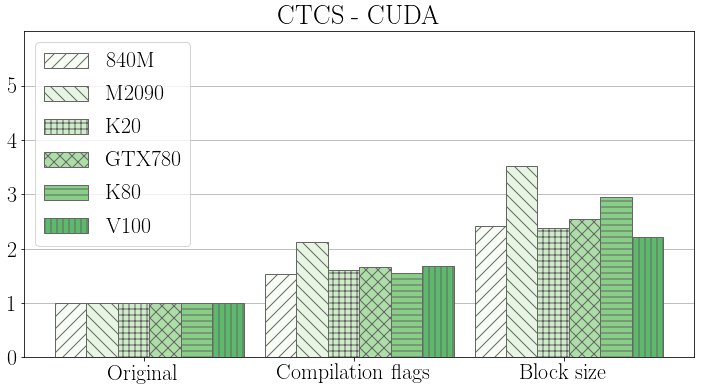

<Figure size 432x288 with 0 Axes>

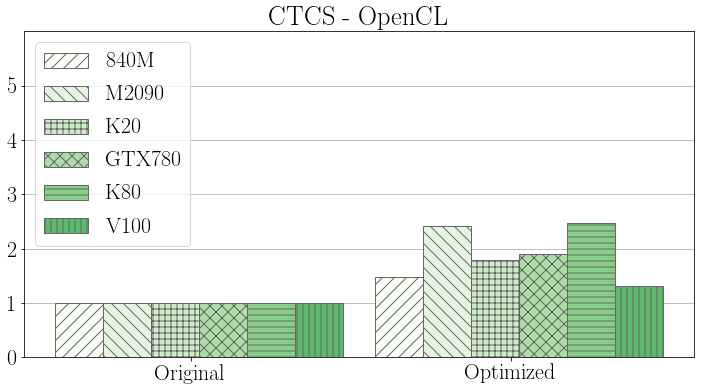

In [8]:
plot_results(ctcs_cuda, "CTCS - CUDA", columns=[0, 7, 8], labels=["Original", "Compilation flags", "Block size"], filename="cuda_ctcs.pdf")
plot_results(ctcs_opencl, "CTCS - OpenCL", labels=["Original", "Optimized"], filename="opencl_ctcs.pdf")

<Figure size 432x288 with 0 Axes>

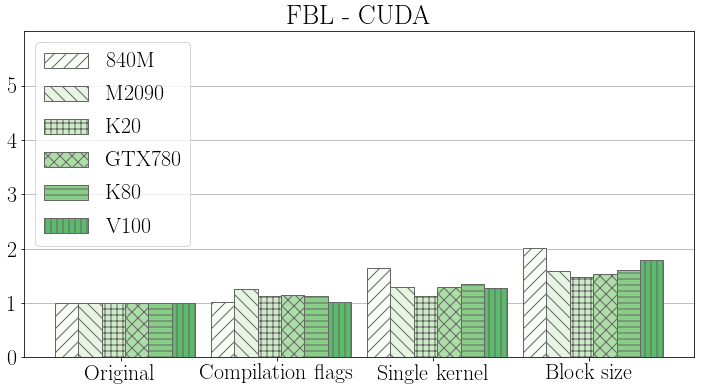

<Figure size 432x288 with 0 Axes>

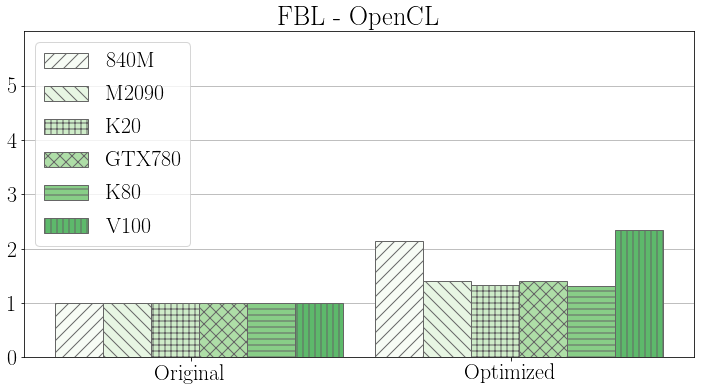

In [9]:
plot_results(fbl_cuda, "FBL - CUDA", labels=["Original", "Compilation flags", "Single kernel", "Block size"], filename="cuda_fbl.pdf")
plot_results(fbl_opencl, "FBL - OpenCL", labels=["Original", "Optimized"], filename="opencl_fbl.pdf")

In [10]:
np.__version__
import os
os

<module 'os' from '/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/os.py'>